In [1]:
%matplotlib inline

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

from joblib import cpu_count, delayed, Parallel
from tqdm import tqdm

from src.displaytools import display_image, get_color
from src.ftextraction import extract_features
from src.improcessing import scale_image
from src.maskcreation import get_mask_image_with_refined_offset

In [2]:
image_stack = cv2.imreadmulti('source_images/Ascl1reporter_brightfield.tif',
                              flags=cv2.IMREAD_GRAYSCALE)[1]
brightfield_images = list(map(scale_image, image_stack[1::2]))
fluorescent_images = image_stack[::2]

In [3]:
mask_images = \
    Parallel(n_jobs=cpu_count())(
        delayed(get_mask_image_with_refined_offset)(_) for _ in tqdm(brightfield_images))

100%|██████████| 153/153 [3:38:40<00:00, 85.75s/it]  


In [4]:
result = \
    Parallel(n_jobs=cpu_count())(
        delayed(extract_features)(*_) for _ in tqdm(zip(brightfield_images, mask_images)))

153it [2:32:39, 59.87s/it]


In [5]:
with open("20220506084724.pickle", "rb") as infile:
    scaler, pca, kmeans = pickle.load(infile)

nc = kmeans.get_params()['n_clusters']

In [6]:
cluster_fluorescences = []
total_fluorescences = []
for i in tqdm(range(len(result))):
    df, mask_labels = result[i]
    labels = kmeans.predict(pd.DataFrame(pca.transform(scaler.transform(df)), index=df.index))

    binarized_fluorescence = \
        cv2.threshold(fluorescent_images[i], 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
    total_fluorescences += [np.sum(np.uint8(binarized_fluorescence > 0)),]
    
    total_cfs = []
    for k in range(nc):
        masks = np.array([np.uint8(mask_labels==idx) for idx in np.where(labels==k)[0]+1])
        if len(masks) > 0:
            combined_mask = np.bitwise_or.reduce(masks, axis=0)
            total_cfs += [np.sum(np.uint8((combined_mask * binarized_fluorescence) > 0)),]
        else:
            total_cfs += [0,]
    cluster_fluorescences += [total_cfs,]
cluster_fluorescences = np.array(cluster_fluorescences).T
total_fluorescences = np.array(total_fluorescences)

100%|██████████| 153/153 [16:09<00:00,  6.33s/it]


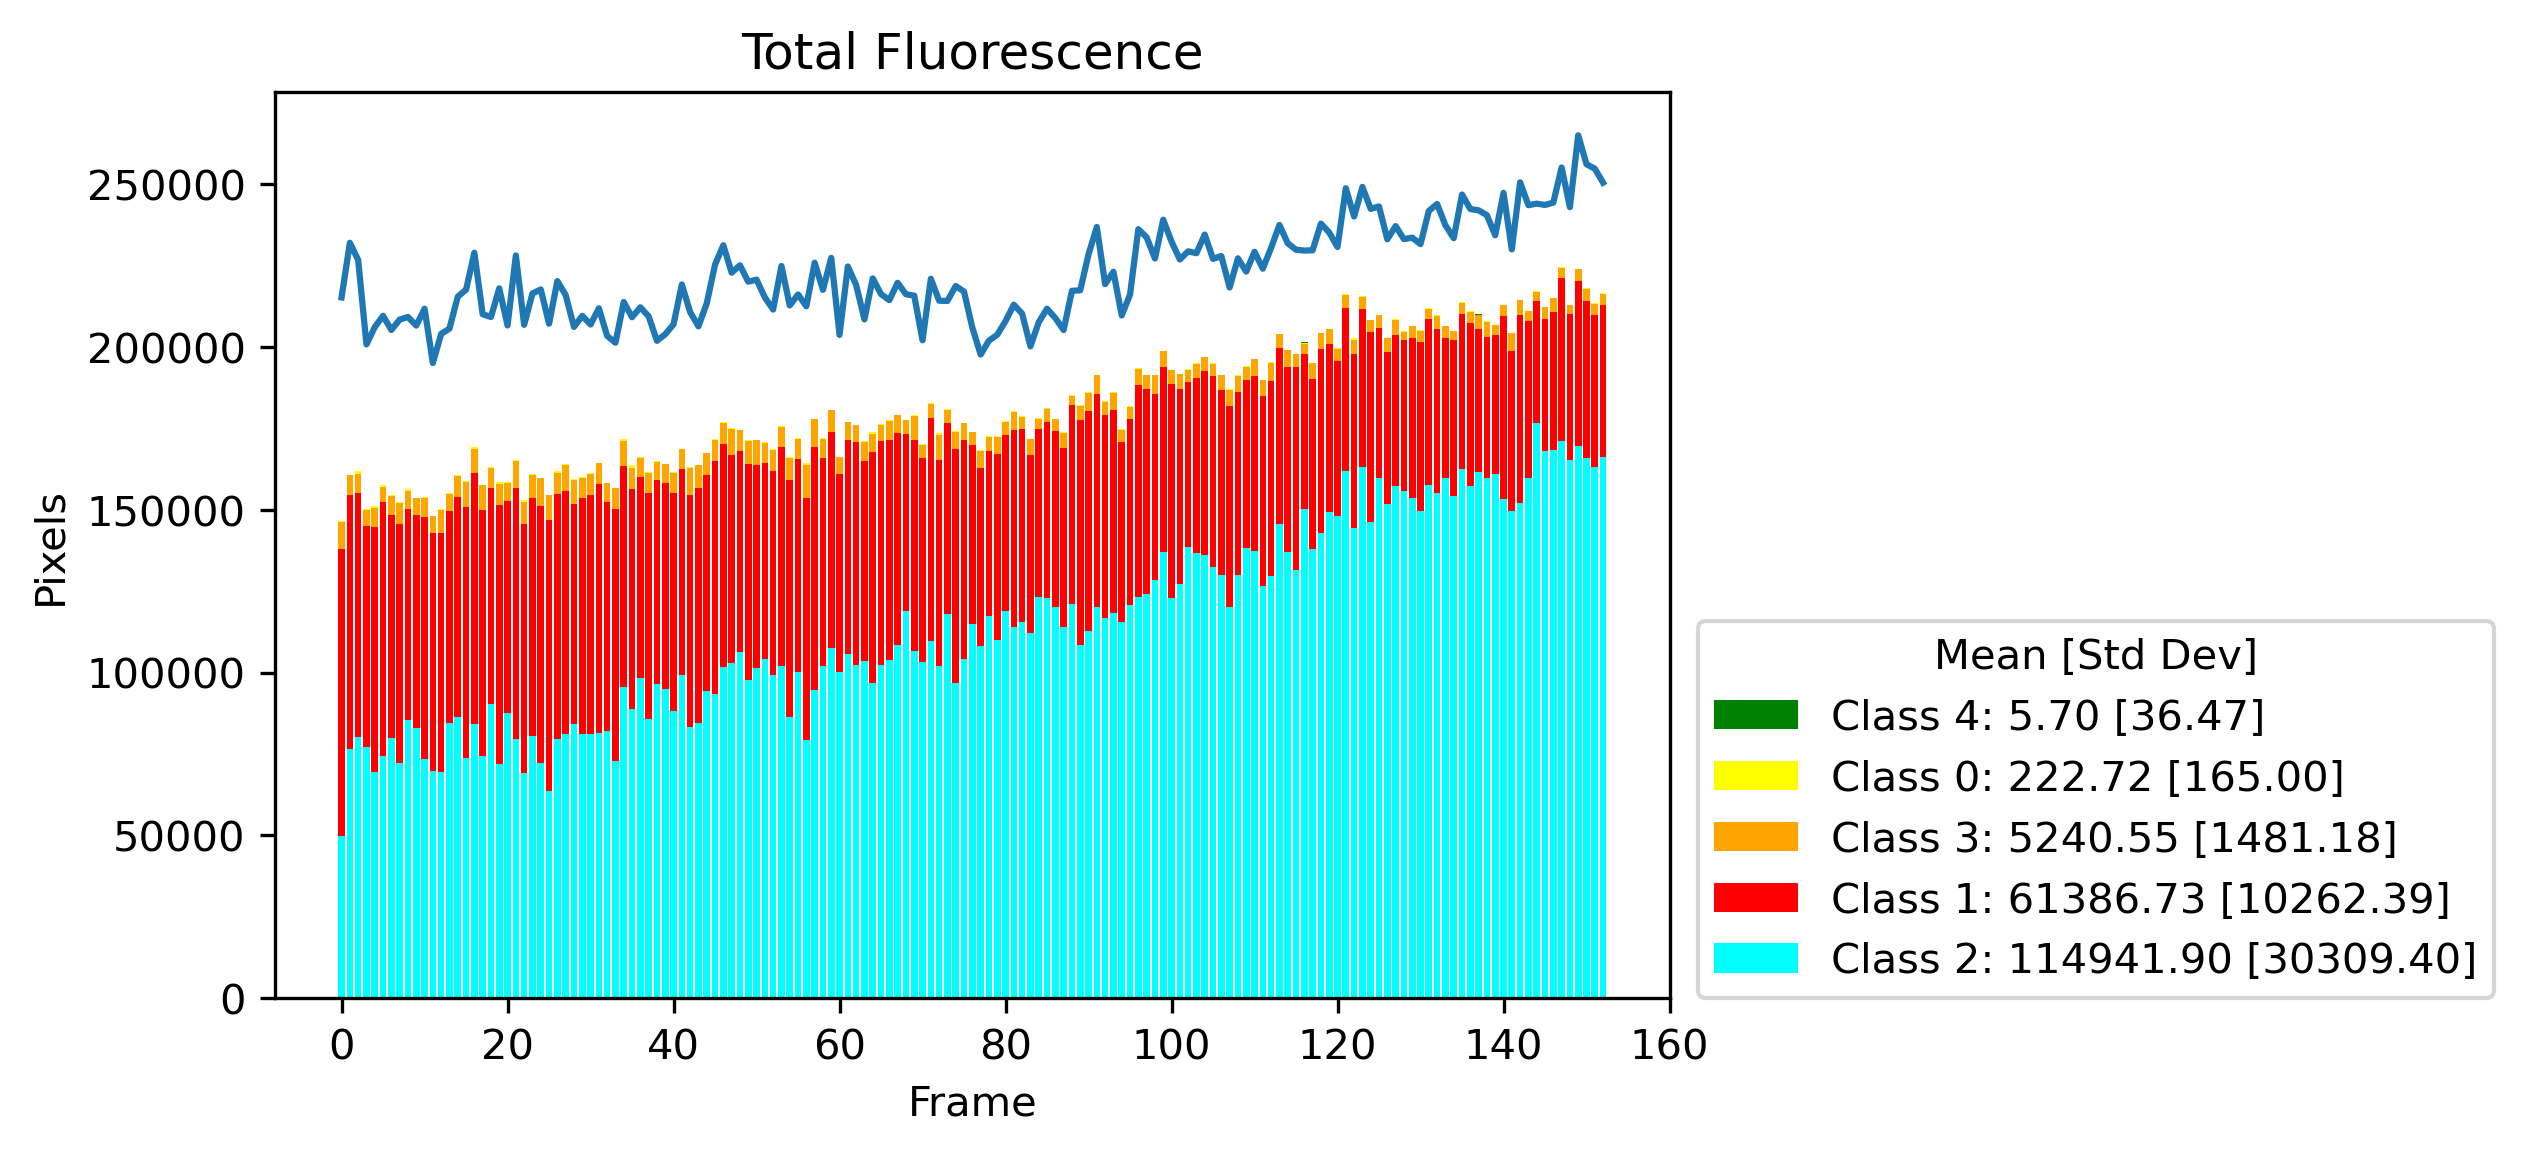

In [8]:
sorted_data = sorted(zip(cluster_fluorescences, list(range(len(cluster_fluorescences))),
                         np.mean(cluster_fluorescences, axis=1), np.std(cluster_fluorescences, axis=1)),
                     reverse=True, key=lambda a: a[2])
bottom = np.zeros(cluster_fluorescences.shape[1])
handles = []
plt.figure(dpi=300)
plt.title("Total Fluorescence")
plt.ylabel("Pixels")
plt.xlabel("Frame")
for c, k, _, _ in sorted_data:
    handles += [plt.bar(range(len(c)), c, bottom=bottom, color=get_color(k)),]
    bottom += c
plt.legend(reversed(handles),
           [("Class %i: %.2f [%.2f]" % a[1:]) for a in reversed(sorted_data)],
           title="Mean [Std Dev]", loc=(1.02, 0))
plt.plot(total_fluorescences)
plt.show()